In [ ]:
#
# code from https://github.com/marcellusruben/medium-resources/blob/main/Text_Classification_BERT/bert_medium.ipynb
# 

%%capture
!pip install transformers

In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [2]:
#datapath = f'/content/drive/My Drive/Medium/bbc-text.csv'

datapath = f'../../datasets/bbc-news/BBC News Train.csv'

df = pd.read_csv(datapath)
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


<Axes: xlabel='Category'>

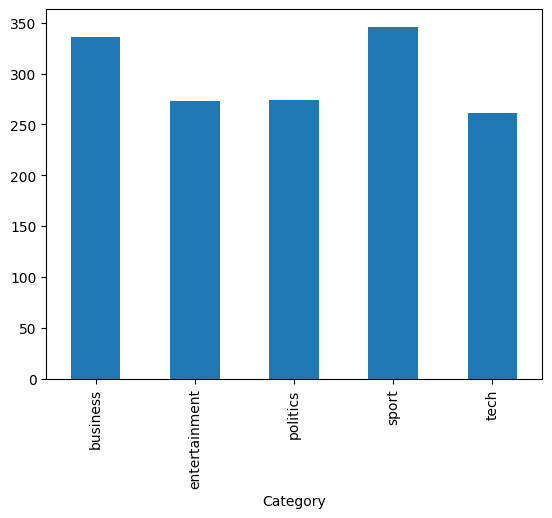

In [4]:
df.groupby(['Category']).size().plot.bar()

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Text']]

        print("labels:", type(labels), len(labels), labels)
        print("texts:", type(self.texts), len(self.texts))
        print("texts[0]:\n", type(self.texts[0]), self.texts[0])
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [11]:
# Setup device prioritizing CUDA, then MPS, then CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f'running on {device}')
 

running on mps


In [6]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [25]:
def train(model, train_data, val_data, learning_rate, epochs, device, batch_size):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    device = device

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    model = model.to(device)
    criterion = criterion.to(device)

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [14]:
def evaluate(model, test_data, batch_size, device):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    model = model.to(device)

    total_acc_test = 0

    with torch.no_grad():
        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [9]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1192 149 149


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [21]:
from sklearn.metrics import f1_score

def evaluate2(model, test_data, batch_size, device):
    
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    total_acc_test = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            preds = output.argmax(dim=1)

            acc = (preds == test_label).sum().item()
            total_acc_test += acc
            
            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(test_label.cpu().numpy())
    
    # Compute F1 scores
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print(f'Macro F1 Score: {macro_f1:.4f}')
    print(f'Micro F1 Score: {micro_f1:.4f}')


In [ ]:
EPOCHS = 10
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, learning_rate=LR,epochs=EPOCHS, device=device, batch_size=8)

labels: <class 'dict'> 5 {'business': 0, 'entertainment': 1, 'sport': 2, 'tech': 3, 'politics': 4}
texts: <class 'list'> 1192
texts[0]:
 <class 'transformers.tokenization_utils_base.BatchEncoding'> {'input_ids': tensor([[  101, 20049,  1233,   118, 12477,  3740,  1110, 13187,  1166, 14708,
          4017,  1103,  2153,  1104,   170,  1492,   118,  1214,   118,  1385,
          1873,  1132, 28117,  1158,  1366, 20247,  4994, 20049,  1233,   118,
         12477,  3740,  1166,   170,   172,  1181,  1118,  2067,  1372,   174,
          5242,  1279, 14797,  1115,  2515,  8222,  1734,   119,  1103,  9680,
          5770,  1107, 13445,  1633,  2514,  1155, 27487,  1116, 20049,  1233,
           118, 12477,  3740,  1260, 21437,  5793,  1118,  1136,  4518,  5183,
         11080,  1113,  1103,  2267,   119,   189,  1874,  6871,   188,  2391,
          5026,  1155, 27487,  1116, 20049,  1233,   118, 12477,  3740,  1450,
          1104,  1103,  1228, 16264,  1937,  1272,  1122,  1125,   172,  5026

 93%|█████████▎| 138/149 [01:21<00:06,  1.79it/s]

In [23]:
evaluate2(model, df_test, batch_size=8, device=device)

Test Accuracy:  0.866
Macro F1 Score: 0.8618
Micro F1 Score: 0.8658
